In [ ]:
# Cell 1 — Imports & load CSV (handles extra blank rows)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

sns.set(style="whitegrid")
pd.options.display.float_format = '{:.4f}'.format

# Path to your uploaded file (update if needed)
file_path = "/content/glass.csv"   # or "/mnt/data/glass.csv"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} not found. Upload the CSV to the notebook environment.")

# Read CSV
df_raw = pd.read_csv(file_path, header=0)
print("Raw shape:", df_raw.shape)
display(df_raw.head(6))


Raw shape: (999, 10)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.5210,13.6400,4.4900,1.1000,71.7800,0.0600,8.7500,0.0000,0.0000,1.0000
1,1.5176,13.8900,3.6000,1.3600,72.7300,0.4800,7.8300,0.0000,0.0000,1.0000
2,1.5162,13.5300,3.5500,1.5400,72.9900,0.3900,7.7800,0.0000,0.0000,1.0000
3,1.5177,13.2100,3.6900,1.2900,72.6100,0.5700,8.2200,0.0000,0.0000,1.0000
4,1.5174,13.2700,3.6200,1.2400,73.0800,0.5500,8.0700,0.0000,0.0000,1.0000
5,1.5160,12.7900,3.6100,1.6200,72.9700,0.6400,8.0700,0.0000,0.2600,1.0000


In [ ]:
# Cell 2 — Clean dataset: drop rows that are all NaN / mostly NaN, ensure numeric types
df = df_raw.copy()

# If there are rows with all NaNs or Type is NaN, drop them
# Drop rows where all feature columns are NaN
df = df.dropna(how='all').reset_index(drop=True)

# If 'Type' column exists but has NaNs, drop those rows too
if 'Type' in df.columns:
    df = df[df['Type'].notna()].reset_index(drop=True)

# Convert numeric columns to proper dtype (coerce errors)
num_cols = ['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Type']
# keep only columns that actually exist in df
num_cols = [c for c in num_cols if c in df.columns]

for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop any remaining rows that contain NaN in all key numeric columns
df = df.dropna(subset=num_cols).reset_index(drop=True)

# Convert Type to integer labels
df['Type'] = df['Type'].astype(int)

print("Cleaned shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst 5 rows:")
display(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())


Cleaned shape: (214, 10)
Columns: ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']

First 5 rows:


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.5210,13.6400,4.4900,1.1000,71.7800,0.0600,8.7500,0.0000,0.0000,1
1,1.5176,13.8900,3.6000,1.3600,72.7300,0.4800,7.8300,0.0000,0.0000,1
2,1.5162,13.5300,3.5500,1.5400,72.9900,0.3900,7.7800,0.0000,0.0000,1
3,1.5177,13.2100,3.6900,1.2900,72.6100,0.5700,8.2200,0.0000,0.0000,1
4,1.5174,13.2700,3.6200,1.2400,73.0800,0.5500,8.0700,0.0000,0.0000,1



Missing values per column:
RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB
None

Statistical summary:


,count,mean,std,min,25%,50%,75%,max
RI,214.0000,1.5184,0.0030,1.5111,1.5165,1.5177,1.5192,1.5339
Na,214.0000,13.4079,0.8166,10.7300,12.9075,13.3000,13.8250,17.3800
Mg,214.0000,2.6845,1.4424,0.0000,2.1150,3.4800,3.6000,4.4900
Al,214.0000,1.4449,0.4993,0.2900,1.1900,1.3600,1.6300,3.5000
Si,214.0000,72.6509,0.7745,69.8100,72.2800,72.7900,73.0875,75.4100
K,214.0000,0.4971,0.6522,0.0000,0.1225,0.5550,0.6100,6.2100
Ca,214.0000,8.9570,1.4232,5.4300,8.2400,8.6000,9.1725,16.1900
Ba,214.0000,0.1750,0.4972,0.0000,0.0000,0.0000,0.0000,3.1500
Fe,214.0000,0.0570,0.0974,0.0000,0.0000,0.0000,0.1000,0.5100
Type,214.0000,2.7804,2.1037,1.0000,1.0000,2.0000,3.0000,7.0000



Duplicate rows count: 1

Target (Type) value counts:
Type
1    70
2    76
3    17
5    13
6     9
7    29
Name: count, dtype: int64


/tmp/ipython-input-3945974206.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Type', data=df, palette='tab10')


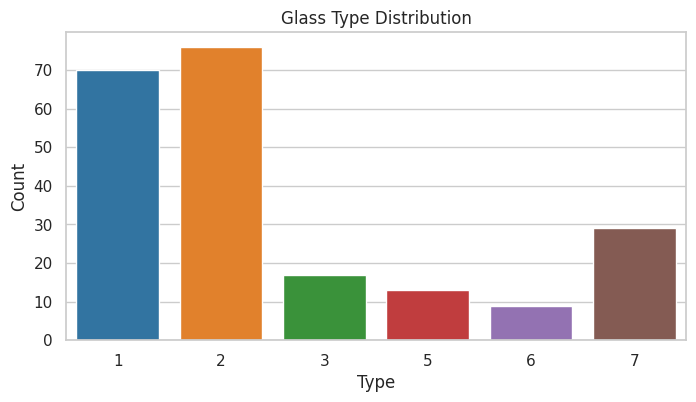

In [ ]:
# Cell 3 — EDA: summary stats, duplicates, distribution
print("Dataset info:")
print(df.info())

print("\nStatistical summary:")
display(df.describe().T)

# Check duplicates
print("\nDuplicate rows count:", df.duplicated().sum())

# Target distribution
print("\nTarget (Type) value counts:")
print(df['Type'].value_counts().sort_index())

plt.figure(figsize=(8,4))
sns.countplot(x='Type', data=df, palette='tab10')
plt.title("Glass Type Distribution")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()


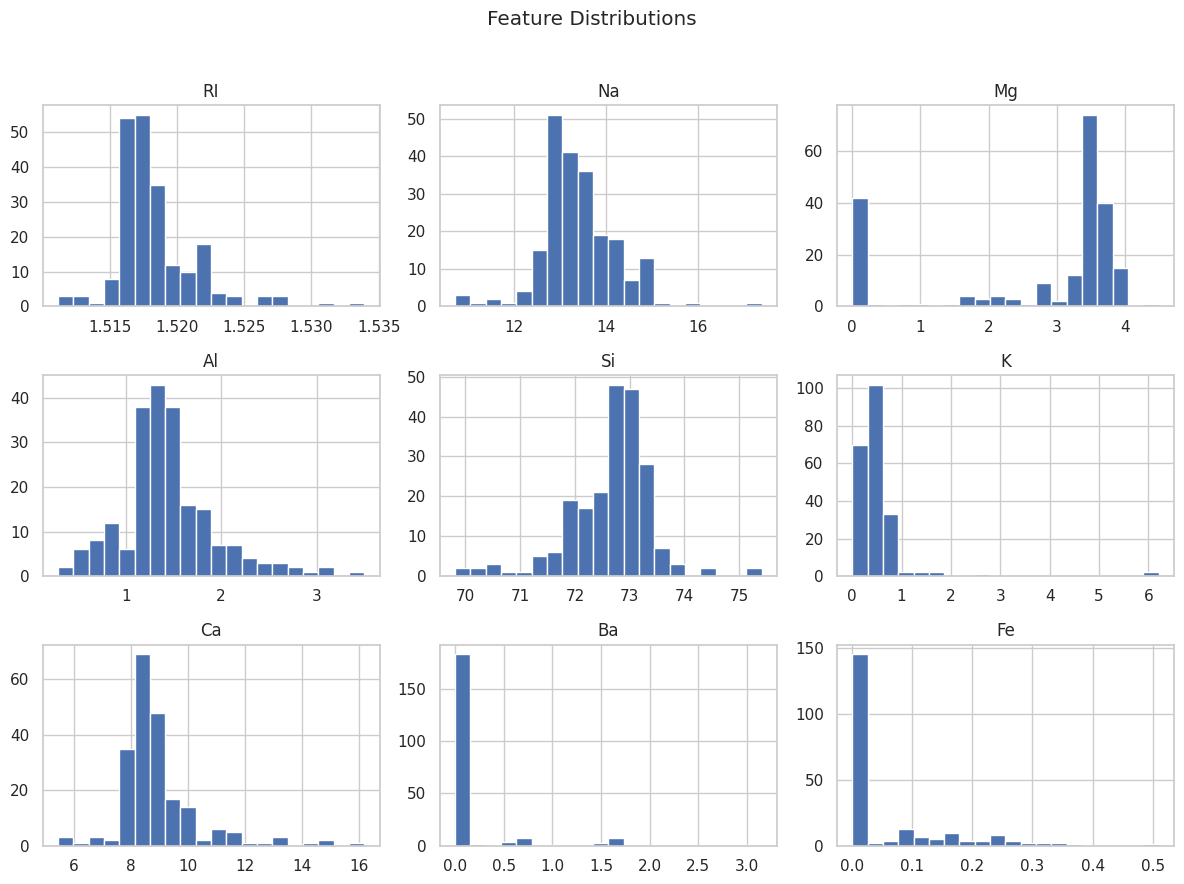

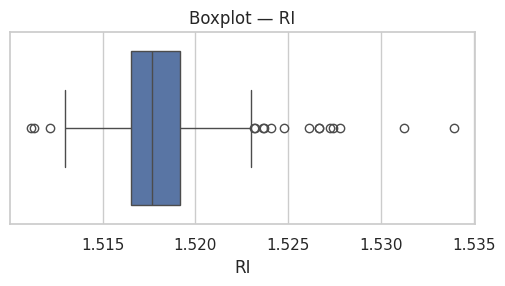

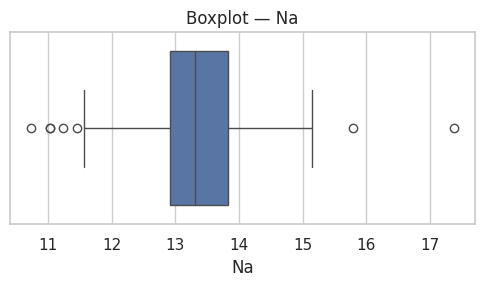

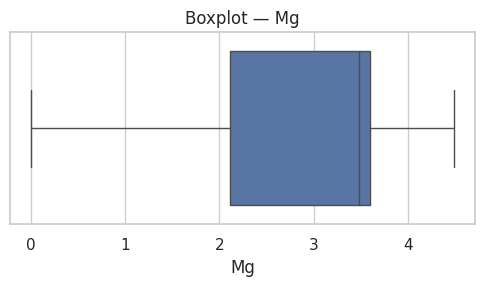

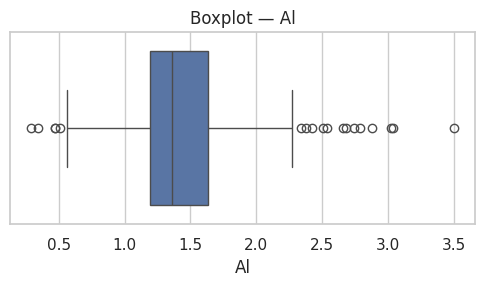

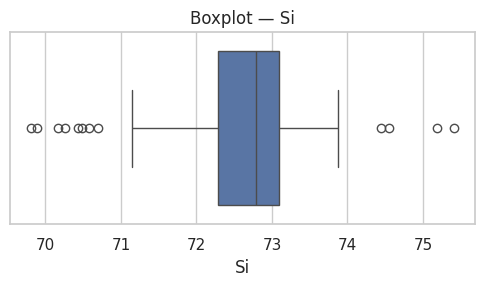

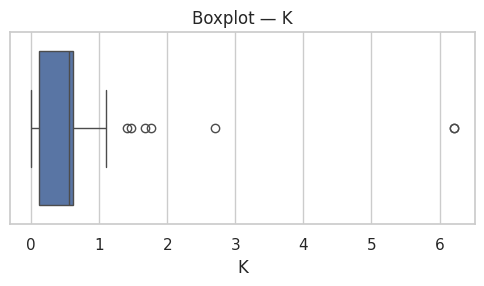

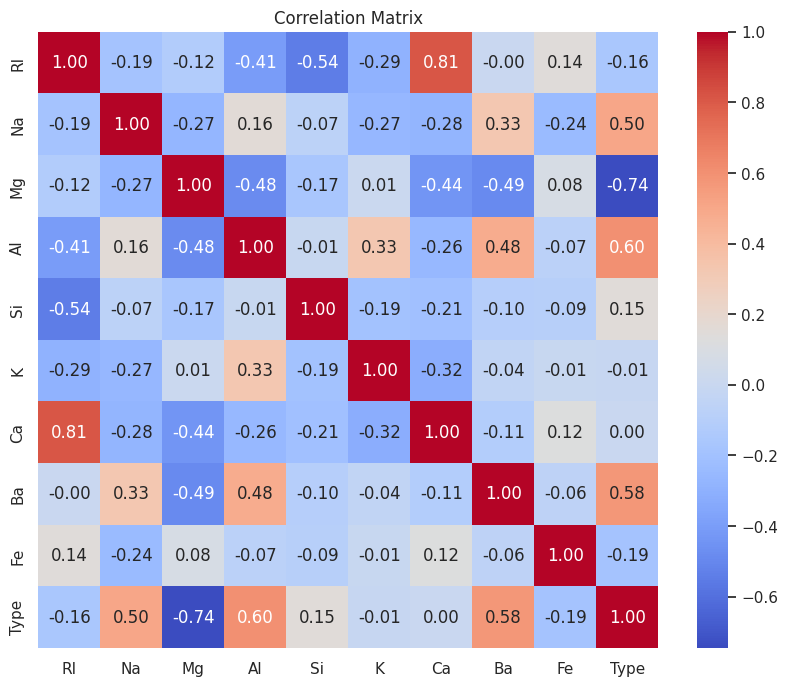

In [ ]:
# Cell 4 — Visualizations: histograms, boxplots and correlation heatmap
numeric_cols = [c for c in df.columns if df[c].dtype in [np.float64, np.int64] and c != 'Type']

# Histograms
df[numeric_cols].hist(figsize=(12,9), bins=20)
plt.suptitle("Feature Distributions")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# Boxplots (first 6 numeric)
for c in numeric_cols[:6]:
    plt.figure(figsize=(6,2.5))
    sns.boxplot(x=df[c])
    plt.title(f"Boxplot — {c}")
    plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols + ['Type']].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=False)
plt.title("Correlation Matrix")
plt.show()



In [ ]:
# Cell 5 — Preprocessing: prepare X and y, scale features, split
X = df.drop(columns=['Type'])
y = df['Type']

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Stratify if possible
stratify_arg = y if y.value_counts().min() >= 2 else None

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=stratify_arg
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())

# Note on imbalance:
print("\nIf your classes are imbalanced, consider using SMOTE (imblearn) or class_weight in models.")


Train shape: (160, 9) Test shape: (54, 9)
Train class distribution:
 Type
2    57
1    52
7    21
3    13
5    10
6     7
Name: count, dtype: int64
Test class distribution:
 Type
2    19
1    18
7     8
3     4
5     3
6     2
Name: count, dtype: int64

If your classes are imbalanced, consider using SMOTE (imblearn) or class_weight in models.


Baseline Random Forest evaluation on test set:
Accuracy: 0.8333333333333334
Precision (weighted): 0.8493967452300786
Recall (weighted): 0.8333333333333334
F1-score (weighted): 0.8290123456790123

Classification report:
               precision    recall  f1-score   support

           1       0.77      0.94      0.85        18
           2       0.88      0.74      0.80        19
           3       1.00      0.50      0.67         4
           5       0.67      0.67      0.67         3
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         8

    accuracy                           0.83        54
   macro avg       0.83      0.81      0.80        54
weighted avg       0.85      0.83      0.83        54



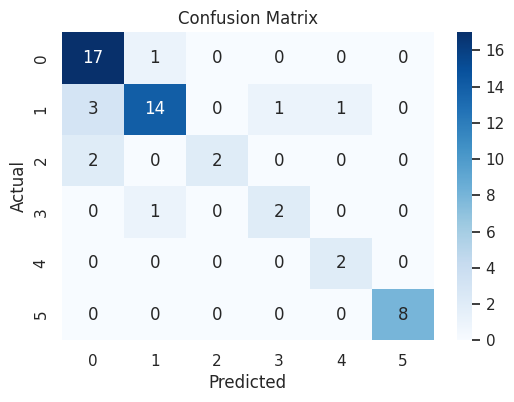

In [ ]:
# Cell 6 — Baseline Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

def print_eval(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (weighted):", precision_score(y_true, y_pred, average='weighted', zero_division=0))
    print("Recall (weighted):", recall_score(y_true, y_pred, average='weighted', zero_division=0))
    print("F1-score (weighted):", f1_score(y_true, y_pred, average='weighted', zero_division=0))
    print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

print("Baseline Random Forest evaluation on test set:")
print_eval(y_test, y_pred)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuned RF performance:
Accuracy: 0.8333333333333334
Precision (weighted): 0.8493967452300786
Recall (weighted): 0.8333333333333334
F1-score (weighted): 0.8290123456790123

Classification report:
               precision    recall  f1-score   support

           1       0.77      0.94      0.85        18
           2       0.88      0.74      0.80        19
           3       1.00      0.50      0.67         4
           5       0.67      0.67      0.67         3
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         8

    accuracy                           0.83        54
   macro avg       0.83      0.81      0.80        54
weighted avg       0.85      0.83      0.83        54



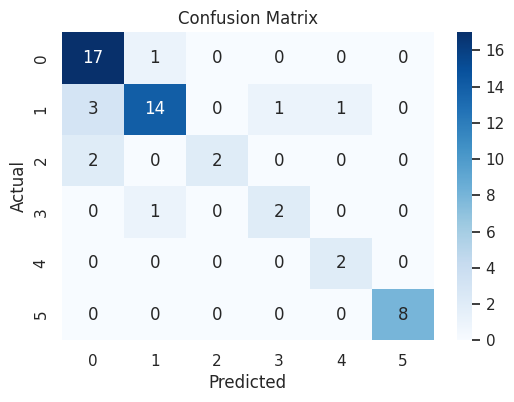

In [ ]:
# Cell 7 — Hyperparameter tuning (small grid to be safe)
from sklearn.model_selection import GridSearchCV, StratifiedKFold

min_count = np.min(y_train.value_counts())
n_splits = 3 if min_count >= 3 else 2
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 6, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Best params:", grid.best_params_)
y_pred_best = best_rf.predict(X_test)
print("Tuned RF performance:")
print_eval(y_test, y_pred_best)



--- RandomForest (tuned)
Accuracy: 0.8333333333333334
Precision (weighted): 0.8493967452300786
Recall (weighted): 0.8333333333333334
F1-score (weighted): 0.8290123456790123

Classification report:
               precision    recall  f1-score   support

           1       0.77      0.94      0.85        18
           2       0.88      0.74      0.80        19
           3       1.00      0.50      0.67         4
           5       0.67      0.67      0.67         3
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         8

    accuracy                           0.83        54
   macro avg       0.83      0.81      0.80        54
weighted avg       0.85      0.83      0.83        54



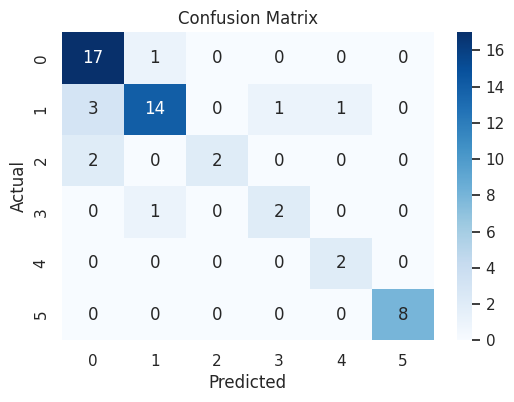


--- Bagging (RF base)
Accuracy: 0.8333333333333334
Precision (weighted): 0.8593034637365413
Recall (weighted): 0.8333333333333334
F1-score (weighted): 0.821484492622704

Classification report:
               precision    recall  f1-score   support

           1       0.74      0.94      0.83        18
           2       0.88      0.79      0.83        19
           3       1.00      0.25      0.40         4
           5       1.00      0.67      0.80         3
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         8

    accuracy                           0.83        54
   macro avg       0.88      0.78      0.78        54
weighted avg       0.86      0.83      0.82        54



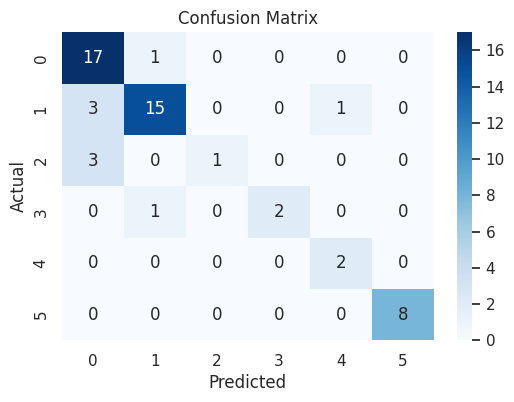


--- AdaBoost (DT base)
Accuracy: 0.4074074074074074
Precision (weighted): 0.4432804232804233
Recall (weighted): 0.4074074074074074
F1-score (weighted): 0.4131313131313132

Classification report:
               precision    recall  f1-score   support

           1       0.42      0.28      0.33        18
           2       0.32      0.42      0.36        19
           3       0.50      0.25      0.33         4
           5       0.17      0.33      0.22         3
           6       0.50      0.50      0.50         2
           7       0.86      0.75      0.80         8

    accuracy                           0.41        54
   macro avg       0.46      0.42      0.43        54
weighted avg       0.44      0.41      0.41        54



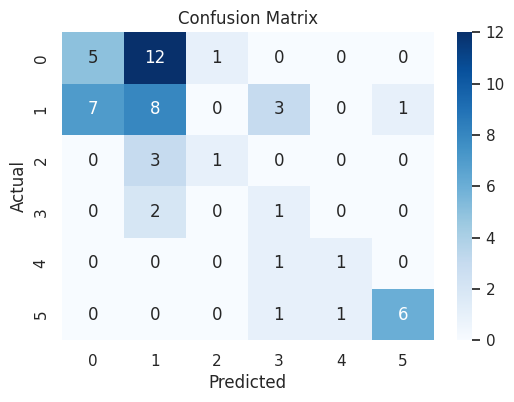


--- GradientBoosting
Accuracy: 0.7777777777777778
Precision (weighted): 0.8001175778953556
Recall (weighted): 0.7777777777777778
F1-score (weighted): 0.7786616070929797

Classification report:
               precision    recall  f1-score   support

           1       0.86      0.67      0.75        18
           2       0.80      0.84      0.82        19
           3       0.67      0.50      0.57         4
           5       0.67      0.67      0.67         3
           6       0.40      1.00      0.57         2
           7       0.89      1.00      0.94         8

    accuracy                           0.78        54
   macro avg       0.71      0.78      0.72        54
weighted avg       0.80      0.78      0.78        54



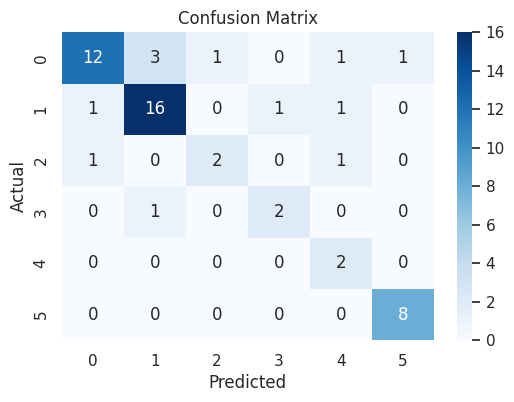


Summary of test accuracies:
RandomForest (tuned): 0.8333
Bagging (RF base): 0.8333
AdaBoost (DT base): 0.4074
GradientBoosting: 0.7778


In [ ]:
# Cell 8 — Bagging and Boosting methods comparison (robust to sklearn version)
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
import inspect

# Helper to create a BaggingClassifier compatible with current sklearn
def make_bagging_with_estimator(estimator, n_estimators=10, random_state=42):
    # Prefer the 'estimator' argument; fall back to 'base_estimator' if necessary.
    sig = inspect.signature(BaggingClassifier.__init__)
    if 'estimator' in sig.parameters:
        return BaggingClassifier(estimator=estimator, n_estimators=n_estimators, random_state=random_state)
    else:
        # older sklearn versions
        return BaggingClassifier(base_estimator=estimator, n_estimators=n_estimators, random_state=random_state)

# Build models
try:
    bagging = make_bagging_with_estimator(RandomForestClassifier(n_estimators=50, random_state=42), n_estimators=10, random_state=42)
except Exception as e:
    print("Bagging construction failed:", e)
    # fallback: use simple Bagging with default base estimator (DecisionTree) to proceed
    bagging = BaggingClassifier(n_estimators=10, random_state=42)

adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

models = {
    'RandomForest (tuned)': best_rf,
    'Bagging (RF base)': bagging,
    'AdaBoost (DT base)': adaboost,
    'GradientBoosting': gb
}

results = {}
for name, model in models.items():
    print("\n---", name)
    try:
        model.fit(X_train, y_train)
        y_pred_m = model.predict(X_test)
        # reuse print_eval() from earlier cell
        print_eval(y_test, y_pred_m)
        results[name] = accuracy_score(y_test, y_pred_m)
    except Exception as e:
        print(f"Model {name} failed with error: {e}")

print("\nSummary of test accuracies:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


In [ ]:
# Cell 9 — Save the best RF model
import joblib
joblib.dump(best_rf, "best_random_forest_glass.pkl")
print("Saved best model to best_random_forest_glass.pkl")


Saved best model to best_random_forest_glass.pkl
